In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from math import floor

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

# Problem set-up

In [9]:
# numeric parameters of the system
m = 1.
k = 500.
bt = 50.
bn = 10.
mu = .5
g = 10.
h = .05

In [10]:
# state: x = (qxb, qyb, qxp, qyp, vxb, vyb)
# input: u = (vxp, vyp)

# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.block([
    [np.zeros((2,4)), np.eye(2)],
    [np.zeros((4,6))]
    ])
B1 = np.block([
    [np.zeros((2,2))],
    [np.eye(2)],
    [np.zeros((2,2))]
    ])
c1 = np.array([0.]*5 + [-g])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.3 (paddle pushing ball, sticking)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A3 = copy(A1)
A3[4,4] = -bt/m
A3[5] = np.array([0., -k/m, 0., k/m, 0., -bn/m])
B3 = copy(B1)
B3[4,0] = bt/m
B3[5,1] = bn/m
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# dynamics n.4 (paddle pushing ball, ball sliding left wrt paddle)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A4 = copy(A3)
A4[4] = mu * A4[5]
B4 = copy(B3)
B4[4] = mu * B4[5]
c4 = np.array([0., 0., 0., 0., mu*g, 0.])
S4 = AffineSystem.from_continuous(A4, B4, c4, h, method)

# dynamics n.5 (paddle pushing ball, ball sliding right wrt paddle)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A5 = copy(A4)
A5[4] = -A5[4]
B5 = copy(B4)
B5[4] = -B5[4]
c5 = -c4
S5 = AffineSystem.from_continuous(A5, B5, c5, h, method)

# list of dynamics
S_list = [S1, S2, S3, S4, S5]

In [11]:
# state: x = (qxb, qyb, qxp, qyp, vxb, vyb)
# input: u = (vxp, vyp)

# state bounds
x_max = np.array([1., 1., 1., .2, 1., 5.])
x_min = - x_max # np.array([-1., -1., -1.2, -.2, -5., -5.])

### limite sulla forza massima

# input bounds
u_max = np.array([1., 1.])
u_min = - u_max

# domain bounds
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

'''
domain n.1, out of contact if:
qyb >= qyp + mg/k
'''
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_inequality(
    np.array([[0., -1., 0., 1., 0., 0., 0., 0.]]),
    np.array([-m*g/k])
)
assert D1.bounded
assert not D1.empty

'''
domain n.2, pulling if:
- qyb <= qyp + mg/k,
- fn = k(qyp-qyb) + bn(vyp-vyb) + mg <= 0
'''
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_inequality(
    np.array([[0., 1., 0., -1., 0., 0., 0., 0.]]),
    np.array([m*g/k])
)
D2.add_inequality(
    np.array([[0., -k, 0., k, 0., -bn, 0., bn]]),
    np.array([-m*g])
)
assert D2.bounded
assert not D2.empty

'''
domain n.3, sticking if:
- qyb <= qyp + mg/k,
- fn = k(qyp-qyb) + bn(vyp-vyb) + mg >= 0,
- ft = bt(vxp-vxb) <= mu fn = mu k(qyp-qyb) + mu bn(vyp-vyb) + mu mg
- ft = bt(vxp-vxb) >= -mu fn = -mu k(qyp-qyb) - mu bn(vyp-vyb) - mu mg
'''
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_inequality(
    np.array([[0., 1., 0., -1., 0., 0., 0., 0.]]),
    np.array([m*g/k])
)
D3.add_inequality(
    np.array([[0., k, 0., -k, 0., bn, 0., -bn]]),
    np.array([m*g])
)
D3.add_inequality(
    np.array([[0., mu*k, 0., -mu*k, -bt, mu*bn, bt, -mu*bn]]),
    np.array([mu*m*g])
)
D3.add_inequality(
    np.array([[0., mu*k, 0., -mu*k, bt, mu*bn, -bt, -mu*bn]]),
    np.array([mu*m*g])
)
assert D3.bounded
assert not D3.empty

'''
domain n.4, ball sliding left wrt paddle if:
- qyb <= qyp + mg/k,
- fn = k(qyp-qyb) + bn(vyp-vyb) + mg >= 0,
- ft = bt(vxp-vxb) >= mu fn = mu k(qyp-qyb) + mu bn(vyp-vyb) + mu mg
'''
D4 = Polyhedron.from_bounds(xu_min, xu_max)
D4.add_inequality(
    np.array([[0., 1., 0., -1., 0., 0., 0., 0.]]),
    np.array([m*g/k])
)
D4.add_inequality(
    np.array([[0., k, 0., -k, 0., bn, 0., -bn]]),
    np.array([m*g])
)
D4.add_inequality(
    np.array([[0., -mu*k, 0., mu*k, bt, -mu*bn, -bt, mu*bn]]),
    np.array([-mu*m*g])
)
assert D4.bounded
assert not D4.empty

'''
domain n.5, ball sliding right wrt paddle if:
- qyb <= qyp + mg/k,
- fn = k(qyp-qyb) + bn(vyp-vyb) + mg >= 0,
- ft = bt(vxp-vxb) <= -mu fn = -mu k(qyp-qyb) - mu bn(vyp-vyb) - mu mg
'''
D5 = Polyhedron.from_bounds(xu_min, xu_max)
D5.add_inequality(
    np.array([[0., 1., 0., -1., 0., 0., 0., 0.]]),
    np.array([m*g/k])
)
D5.add_inequality(
    np.array([[0., k, 0., -k, 0., bn, 0., -bn]]),
    np.array([m*g])
)
D5.add_inequality(
    np.array([[0., -mu*k, 0., mu*k, -bt, -mu*bn, bt, mu*bn]]),
    np.array([-mu*m*g])
)
assert D5.bounded
assert not D5.empty

# list of domains
D_list = [D1, D2, D3, D4, D5]

In [12]:
# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

# controller parameters
N = 20
Q = np.diag([1.,1.,1.,1.,.1,.1])*h
R = np.diag([5.,1.])*h

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros(6)]*2)

In [13]:
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method='Convex hull')
# controller.prog.setParam('Heuristics', 0)

In [14]:
# initial condition
x0 = np.array([0.,1.,0.,0.,.5,0.])
# x0 = np.array([0.2,0.,0.,0.,0.,0.])

In [15]:
u, x, ms, cost = controller.feedforward(x0)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 3420 rows, 1666 columns and 11140 nonzeros
Model has 166 quadratic objective terms
Variable types: 1566 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-03, 2e-01]
  Bounds range     [5e-01, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2249 rows and 1060 columns
Presolve time: 0.03s
Presolved: 1171 rows, 606 columns, 4015 nonzeros
Presolved model has 122 quadratic objective terms
Variable types: 548 continuous, 58 integer (58 binary)

Root relaxation: objective 2.858321e-01, 3132 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.28583    0   47          -    0.28583      -     -    0s
     0     0    0.28584    0   47          -    0.2858

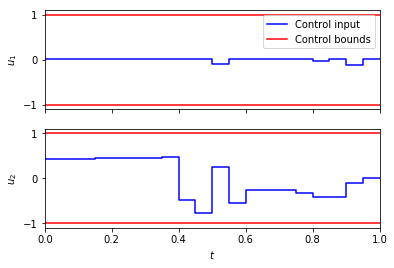

In [16]:
plot_input_sequence(u, h, (u_min, u_max))

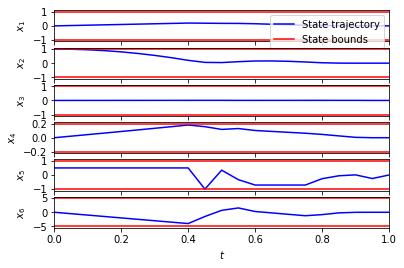

In [17]:
plot_state_trajectory(x, h, (x_min, x_max))

# With my B&B

In [ ]:
from pympc.control.hybrid_benchmark.branch_and_bound import branch_and_bound, best_first, depth_first

In [ ]:
def solver(identifier, objective_cutoff):
    return controller.solve_relaxation(x0, identifier, objective_cutoff)

In [ ]:
methods = [
#     'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]

lb = {}
ub = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    sol, lb_i, ub_i = branch_and_bound(solver, best_first, controller.explore_in_chronological_order)
    lb[method] = lb_i
    ub[method] = ub_i
np.save('lb_2d', lb)
np.save('ub_2d', ub)

In [ ]:
# format x axis to write nk instead of n000
from matplotlib.ticker import FuncFormatter
def thousands(x, pos):
    return '%1.1fk' % (x*1e-3)
formatter = FuncFormatter(thousands)

mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)
colors = ['g', 'c', 'r','b']
linestyles = [':', '--', '-.', '-']
for i, method in enumerate(methods):
    plt.plot(lb[method]/max(lb[method]), label=method, color=colors[i], linestyle=linestyles[i], linewidth=3)
#     plt.plot(ub[method]/sol['objective'], color=colors[i], linestyle=linestyles[i], linewidth=3,zorder=0)
    plt.scatter(len(lb[method]), 1, color=colors[i], marker='x', s=300)

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
    
plt.xlim((0, 1.05*max([len(lb[method]) for method in methods])))
plt.ylim((.95, 1.005))
plt.legend()
plt.grid(True)
plt.xlabel(r'Nodes in B&B tree')
plt.ylabel(r'Lower bound B&B / cost MICP')
# plt.savefig('relaxation_ratio.pdf', bbox_inches='tight')
plt.show()

# Animation

In [18]:
import meshcat
from meshcat.geometry import Box, MeshLambertMaterial
from meshcat.animation import Animation
import meshcat.transformations as tf

In [19]:
# x, ms = S.simulate(x0, [np.zeros(S.nu)]*200)

In [20]:
vis = meshcat.Visualizer()
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [21]:
paddle_height = .2
box_height = .1
red = 0xff2222
blue = 0x2222ff
vis['paddle'].set_object(Box([.1, 1., paddle_height]), MeshLambertMaterial(color=red))
vis['box'].set_object(Box([.11, .1, box_height]), MeshLambertMaterial(color=blue))

In [22]:
anim = Animation()
for t in range(len(x)):
    with anim.at_frame(vis, t*h*150) as frame:
        frame['paddle'].set_transform(tf.translation_matrix([0, x[t][2], x[t][3]+m*g/k-paddle_height/2.]))
        frame['box'].set_transform(tf.translation_matrix([0, x[t][0], x[t][1]+box_height/2.]))
vis.set_animation(anim)